In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import json
import pandas as pd

In [2]:
def myrate(t, r):
    if t>=17 and t<85:
        return r
    else:
        return 1

In [3]:
def mymodel(t, z, beta, mu, gamma, fD, delta_c, k, nu, r):
    S = z[0]
    E = z[1]
    I = z[2]
    R = z[3]
    H = z[4]
    D = z[5]
    dD = gamma_H*H
    dH = fD*gamma*I - gamma_H*H - nu*H
    dR = (1-fD)*gamma*I + nu*H
    dI = mu*E - gamma*I
    dS = -beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k)
    dE = beta*S*I*myrate(t, r)/(1+(dD/delta_c)**k) - mu*E 
    return [dS, dE, dI, dR, dH, dD]

In [4]:
def two_rate(t, r1, r2):
    if t>=17 and t<28:
        return r1
    elif t>=28 and t<85:
        return r2
    else:
        return 1

def twostep_model(t, z, beta, mu, gamma, fD, delta_c, k, nu, r1, r2):
    S = z[0]
    E = z[1]
    I = z[2]
    R = z[3]
    H = z[4]
    D = z[5]
    dD = gamma_H*H
    dH = fD*gamma*I - gamma_H*H - nu*H
    dR = (1-fD)*gamma*I + nu*H
    dI = mu*E - gamma*I
    dS = -beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k)
    dE = beta*S*I*two_rate(t, r1, r2)/(1+(dD/delta_c)**k) - mu*E 
    return [dS, dE, dI, dR, dH, dD]

In [32]:
beta = 2
mu = 0.2
gamma = 0.145
gamma_H = 0.022
fD = 0.08
k = 1
nu = 0.048
r = 0.31
r1 = 0.36
r2 = 0.26
delta_c = (50/60)*1e-6

In [33]:
E0 = 1695
I0 = 308.8
H0 = 127.4
R0 = 311.1
S0 = 60.352*1e6
D0 = 0
N0 = E0+I0+H0+R0+S0
z0 = np.array([S0, E0, I0, R0, H0, D0])/N0

In [34]:
sol = solve_ivp(mymodel, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r))
sol2 = solve_ivp(twostep_model, [0,85], z0, dense_output=True, args=(beta, mu, gamma, fD, delta_c, k, nu, r1, r2))

In [35]:
t = np.arange(85)
x = sol.sol(t)
S = x[0].T
E = x[1].T
I = x[2].T
R = x[3].T
H = x[4].T
D = x[5].T

In [36]:
x2 = sol2.sol(t)
S2 = x2[0].T
E2 = x2[1].T
I2 = x2[2].T
R2 = x2[3].T
H2 = x2[4].T
D2 = x2[5].T

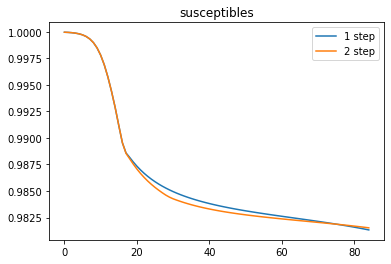

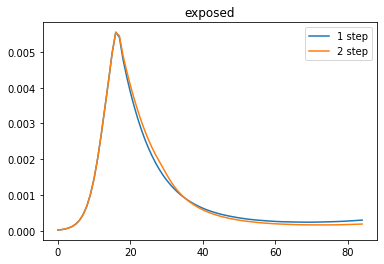

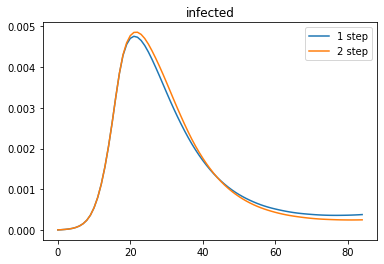

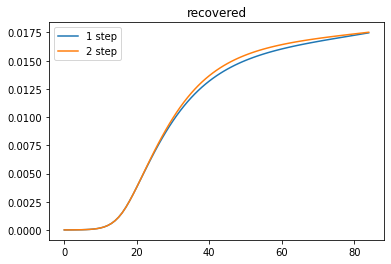

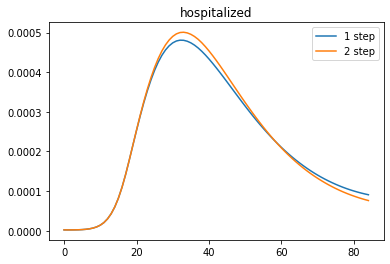

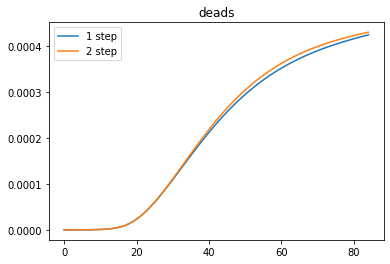

In [37]:
names = ['susceptibles', 'exposed', 'infected', 'recovered', 'hospitalized', 'deads']
for i,(col,col2) in enumerate(zip(x, x2)):
    plt.figure(i)
    plt.plot(t, col.T, label = '1 step')
    plt.plot(t, col2.T, label = '2 step')
    plt.legend()
    plt.title(names[i])

In [38]:
f = open('covid_data_dpc.json')
raw_data = json.load(f)

In [39]:
#from dictionary to dataframe
df = pd.DataFrame.from_dict(raw_data)
df.head()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,...,tamponi,casi_testati,note,ingressi_terapia_intensiva,note_test,note_casi,totale_positivi_test_molecolare,totale_positivi_test_antigenico_rapido,tamponi_test_molecolare,tamponi_test_antigenico_rapido
0,2020-02-24T18:00:00,ITA,101,26,127,94,221,0,221,1,...,4324,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
1,2020-02-25T18:00:00,ITA,114,35,150,162,311,90,93,1,...,8623,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
2,2020-02-26T18:00:00,ITA,128,36,164,221,385,74,78,3,...,9587,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
3,2020-02-27T18:00:00,ITA,248,56,304,284,588,203,250,45,...,12014,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN
4,2020-02-28T18:00:00,ITA,345,64,409,412,821,233,238,46,...,15695,NaN,None,NaN,None,None,NaN,NaN,NaN,NaN


In [40]:
# columns names
df.columns

Index(['data', 'stato', 'ricoverati_con_sintomi', 'terapia_intensiva',
       'totale_ospedalizzati', 'isolamento_domiciliare', 'totale_positivi',
       'variazione_totale_positivi', 'nuovi_positivi', 'dimessi_guariti',
       'deceduti', 'casi_da_sospetto_diagnostico', 'casi_da_screening',
       'totale_casi', 'tamponi', 'casi_testati', 'note',
       'ingressi_terapia_intensiva', 'note_test', 'note_casi',
       'totale_positivi_test_molecolare',
       'totale_positivi_test_antigenico_rapido', 'tamponi_test_molecolare',
       'tamponi_test_antigenico_rapido'],
      dtype='object')

In [41]:
# dataframe with reduced dates
# from 24/02 to 18/05 
df_red = df.loc[0:84]

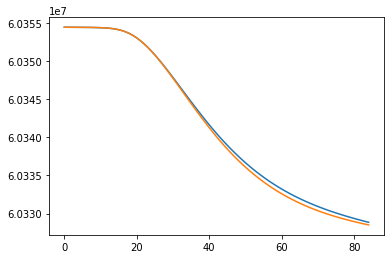

In [42]:
N = N0*(S+E+I+R+H)
N2 = N0*(S2+E2+I2+R2+H2)
plt.plot(t,N)
plt.plot(t,N2)

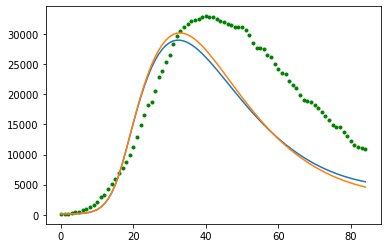

In [43]:
plt.plot(t, df_red['totale_ospedalizzati'], 'g.', label = 'data')
plt.plot(t, H*N)
plt.plot(t, H2*N2)
plt.show()